# 🔥포스🔥

### 위 게시글을 시리즈물📖입니다.  
**[1편. OpenCV의 기초, Numpy와 Matplotlib](https://dacon.io/codeshare/4768?page=1&dtype=recent)**<br>
**[2편. OpenCV 기초(이미지 입출력, 그리기, 창 관리, 이벤트 처리 등)](https://dacon.io/codeshare/4837?page=1&dtype=recent)**<br>
**[3편. 이미지 프로세싱(컬러 스페이스, 스레시홀딩, 이미지 연산, 히스토그램)](https://dacon.io/codeshare/4858?page=1&dtype=recent)**<br>
**[4편. OpenCV 기하학적 변환](https://dacon.io/codeshare/4875?page=1&dtype=recent)**<br>
**[5편. OpenCV 영상필터](https://dacon.io/codeshare/4898?page=1&dtype=recent)**

* 안녕하세요 :) 데이크루 2기 *포스팀*입니다!
* 포스팀은 OpenCV 공부와 프로젝트를 같이 병행합니다! 
* 오늘은!! 포스팀이 만든 **프로젝트**를 발표하는 게시글입니다! 


**주제는!!!**

## ✨
## Multi Hand Gesture Reconition(두 손 동작 인식) 
## ✨


## 목차
### 1. 개요
### 2. 데이터 설명
### 3. 모형 설명
### 4. 코드
### 5. 과적합 방지 기법
####    5-1) Dropout
####    5-2) Batch Normalization
####    5-3) Early Stopping
####    5-4) L1, L2 규제
### 6. 최종 모형
### 7. 결론

# 그럼 시작합니다 :)


### 1. 개요

코로나로 인해 비대면으로 진행되는 업무가 많이 생겼습니다. 가령 수업, 미팅 등 입니다. 이렇게 비대면 수요가 높아지다보니 영상에서 어떤 task를 이용한 사업들도 많이 나왔습니다. 최근 기사에서는 '비대면 술자리' 라는 콘텐츠로 화면에서 물체를 분류하거나 처리하여 게임에 적용하는 등 많은 사례가 나오고 있습니다. 이에, 동작을 인식하는 프로젝트를 하면서 실제 현업에서 적용된 사례를 간단하게나마 구현해보고 더 나아가 모든 비대면 업무 참가자들이 마이크나 채팅을 통해 대답하는 것보다 손 동작을 인식함으로써 효율적인 의사소통을 기대하는 마음으로 프로젝트를 진행하였습니다. 



### 2. 데이터 소개


<img src ="https://drive.google.com/uc?export=view&id=1JA1k8NBiVBDNNco5sZJwmAaTX5nXvhv_">



분류하고자 하는 손 동작 인식은 두 손을 이용한 동작 인식입니다. 사용한 동작은 총 4가지 입니다.

- yes : 두 손을 동그랗게 모아 o를 나타내는 동작입니다.
- no : 두 손을 cross하여 x를 나타내는 동작입니다.
- like : 두 손으로 엄지척을 하는 동작입니다.
- heart : 두 손으로 하트를 그리는 동작입니다.



### 3. 모형 설명

Base Model로 딥러닝 중 **LSTM(Long Short Term Memory)**을 사용하였습니다. 장/단기 기억을 가능하게 설계한 신경망 구조를 의미하는 LSTM은 주로 시계열 처리나 자연어 처리에 많이 사용되곤 합니다. 여기에서는 동작의 움직임을 frame 당으로 바꾸어 vector로 만들어 input으로 들어갑니다.

### 4. 코드

#### 데이터 합치기

위 단계에서는 yes, no, like, heart인 4가지 동작 각각의 인식을 담은 배열 npy 파일을 합치려고 합니다.

In [ ]:
data_yes = np.load('dataset/seq_yes_1652512945.npy')
data_no = np.load('dataset/seq_no_1652512945.npy')
data_like = np.load('dataset/seq_like_1652512945.npy')
data_heart = np.load('dataset/seq_heart_1652512945.npy')

print(data_yes.shape)
print(data_no.shape)
print(data_like.shape)
print(data_heart.shape)

(1006, 10, 111)
(770, 10, 111)
(1073, 10, 111)
(1143, 10, 111)


In [ ]:
actions = ['yes', 'no', 'like', 'heart']

data = np.concatenate([
    np.load('dataset/seq_yes_1652512945.npy'),
    np.load('dataset/seq_no_1652512945.npy'),
    np.load('dataset/seq_like_1652512945.npy'),
    np.load('dataset/seq_heart_1652512945.npy'),
], axis=0)

data.shape

(3992, 10, 111)

#### 데이터 x, y 나누기

In [ ]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(3992, 10, 110)
(3992,)


In [ ]:
np.unique(labels)

array([0., 1., 2., 3.])

In [ ]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3992, 4)

#### X,y train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(1)

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2994, 10, 110) (2994, 4)
(998, 10, 110) (998, 4)


#### 판단 척도

판단 척도는 **F1 score**를 사용하였습니다. **F1 score**는 정밀도와 재현율을 결합한 지표로 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을 때 높은 값을 나타냅니다.

In [ ]:
import tensorflow as tf
def metric_F1score(y_true,y_pred): 
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1score=2*precision*recall/(precision+recall)
    return F1score

####  Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric_F1score])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                44800     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 47,012
Trainable params: 47,012
Non-trainable params: 0
_________________________________________________________________


#### Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_metric_F1score', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
94/94 [==============================] - 5s 39ms/step - loss: 19.8059 - metric_F1score: 0.4988 - val_loss: 1.9830 - val_metric_F1score: 0.8410

Epoch 00001: val_metric_F1score improved from inf to 0.84099, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/50
94/94 [==============================] - 1s 9ms/step - loss: 2.4794 - metric_F1score: 0.8664 - val_loss: 1.8825 - val_metric_F1score: 0.8697

Epoch 00002: val_metric_F1score did not improve from 0.84099
Epoch 3/50
94/94 [==============================] - 1s 8ms/step - loss: 1.5710 - metric_F1score: 0.8912 - val_loss: 0.4678 - val_metric_F1score: 0.9658

Epoch 00003: val_metric_F1score did not improve from 0.84099
Epoch 4/50
94/94 [==============================] - 1s 6ms/step - loss: 0.3725 - metric_F1score: 0.9751 - val_loss: 0.4184 - val_metric_F1score: 0.9707

Epoch 00004: val_metric_F1score did not improve from 0.84099
Epoch 5/50
94/94 [==============================] - 1s 8ms/step - loss: 0.3537 - metr


Epoch 00038: val_metric_F1score did not improve from 0.84099
Epoch 39/50
94/94 [==============================] - 0s 4ms/step - loss: 1.3582e-05 - metric_F1score: 1.0000 - val_loss: 0.0134 - val_metric_F1score: 0.9980

Epoch 00039: val_metric_F1score did not improve from 0.84099
Epoch 40/50
94/94 [==============================] - 0s 4ms/step - loss: 2.7582e-05 - metric_F1score: 1.0000 - val_loss: 0.0134 - val_metric_F1score: 0.9980

Epoch 00040: val_metric_F1score did not improve from 0.84099
Epoch 41/50
94/94 [==============================] - 0s 4ms/step - loss: 2.6617e-05 - metric_F1score: 1.0000 - val_loss: 0.0134 - val_metric_F1score: 0.9980

Epoch 00041: val_metric_F1score did not improve from 0.84099
Epoch 42/50
94/94 [==============================] - 0s 4ms/step - loss: 1.0350e-05 - metric_F1score: 1.0000 - val_loss: 0.0135 - val_metric_F1score: 0.9980

Epoch 00042: val_metric_F1score did not improve from 0.84099
Epoch 43/50
94/94 [==============================] - 0s 4ms/st

####  Results Analysis

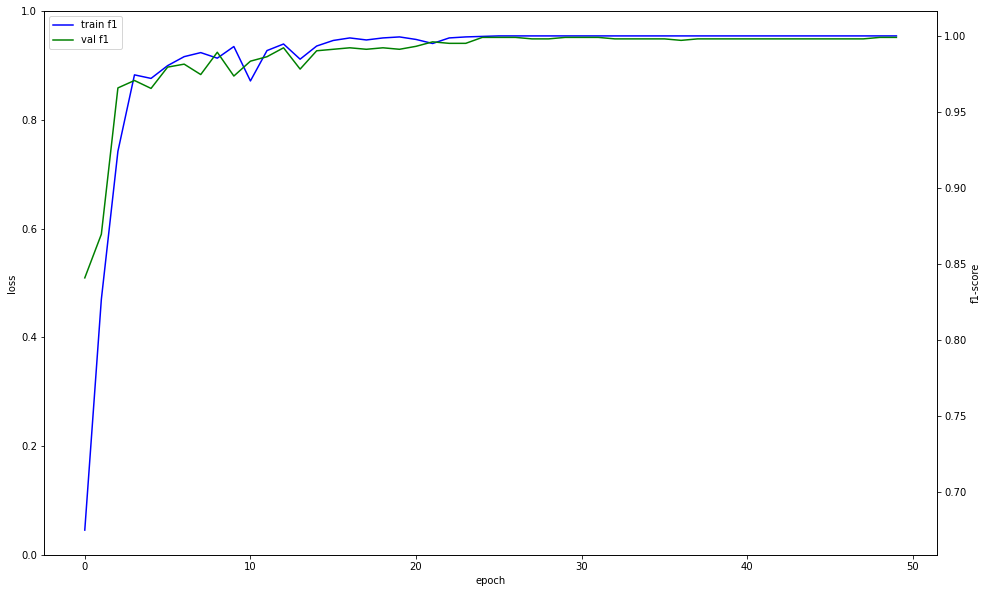

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

y_pred = model.predict(x_val)
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[730,   1],
        [  0, 267]],

       [[797,   0],
        [  1, 200]],

       [[731,   0],
        [  0, 267]],

       [[735,   0],
        [  0, 263]]], dtype=int64)

결과를 살펴보면 엄청난 과적합이 일어난 것을 확인할 수 있습니다. 이를 과적합 방지 기법을 이용하여 살펴보겠습니다.

### 5. 과적합 방지 기법

####  5-1) Dropout

Dropout이란 서로 연결된 연결망에서 0부터 1사이의 확률로 선택적으로 노드를 제거하는 기법입니다.

좀 더 쉽게 설명하자면 너무 똑똑해지는 것을 방지하기 위해 (**과적합방지**) 인간처럼 기억을 잊어버릴 수 있게 한 것을 의미합니다.

Dropout을 적용하여 상관관계가 강한 Feature를 제외하고 학습해도 좋은 출력값을 얻을 수 있도록 최적화되었다면, 해당 Feature에만 출력값이 영향을 미치는 과대적합을 방지할 수 있습니다.

<img src ="https://drive.google.com/uc?export=view&id=14zvrerxFy0kvBfV7qpOM2rpdo9xu_j8L">

기존 모형에 이미 dropout 기법이 들어있지만 들어있는 계수의 값이 작다고 생각이 들어 값을 올려서 진행을 하도록 하겠습니다.

- **tensorflow.layer.Dropout(rate, noise_shape=None, seed=None, **kwargs)**
    - rate : 0과 1 사이의 부동 소수점, 삭제할 입력 단위의 비율
    - noise_shape : 입력과 곱할 바이너리 드롭아웃 마스크 모양을 나타내는 1D 정수 텐서
    - seed : 임의의 seed

In [ ]:
# 수정 요망
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model2 = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(actions), activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model2.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
94/94 [==============================] - 2s 8ms/step - loss: 34.1904 - acc: 0.3890 - metric_F1score: 0.3876 - val_loss: 0.1916 - val_acc: 0.9649 - val_metric_F1score: 0.9627

Epoch 00001: val_acc improved from -inf to 0.96493, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/50
94/94 [==============================] - 0s 5ms/step - loss: 1.2209 - acc: 0.8059 - metric_F1score: 0.7983 - val_loss: 0.1046 - val_acc: 0.9709 - val_metric_F1score: 0.9646

Epoch 00002: val_acc improved from 0.96493 to 0.97094, saving model to models\multi_hand_gesture_classifier.h5
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 0.6393 - acc: 0.8685 - metric_F1score: 0.8471 - val_loss: 0.1690 - val_acc: 0.9599 - val_metric_F1score: 0.9548

Epoch 00003: val_acc did not improve from 0.97094
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 0.5815 - acc: 0.8698 - metric_F1score: 0.8529 - val_loss: 0.1001 - val_acc: 0.9760 - val_metric_F1score

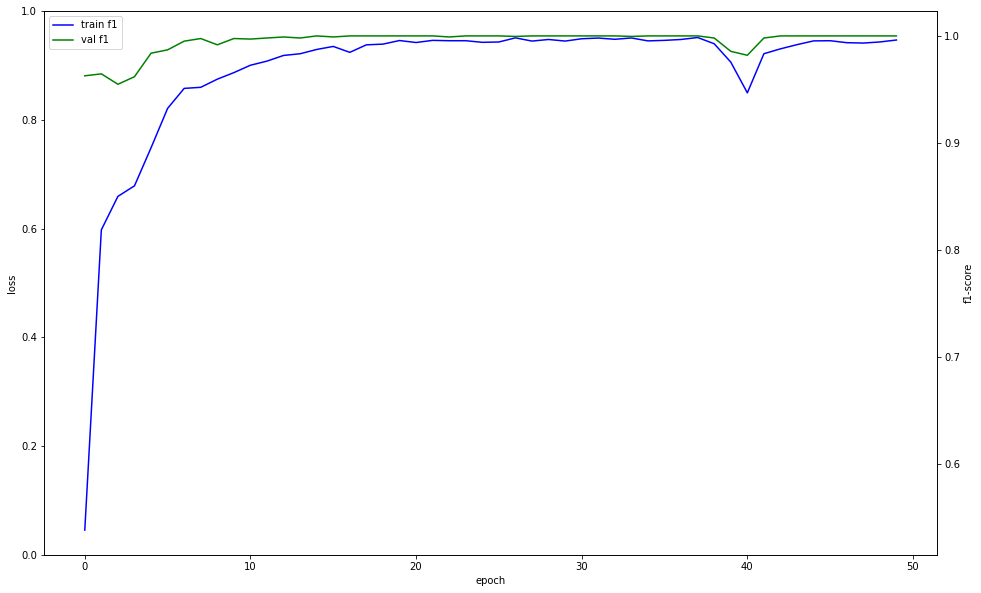

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

훨씬 요동치는 사실을 알게 되었습니다.

#### 5-2) Batch Normalization

Batch Normalization은 배치 정규화라고 합니다. 이는 2015년에 제안된 방법인데 효과가 입증되어 많이 쓰이는 기법입니다. 배치 정규화는 과적합을 방지하고 초기값에 크게 의존하지 않으며 학습 속도가 개선되는 장점도 가지고 있습니다.

- **tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    **kwargs
)**

- 기본 값만 해도 엄청 많습니다. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

model3 = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(len(actions), activation='softmax')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history3 = model3.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
94/94 [==============================] - 3s 8ms/step - loss: 1.0378 - acc: 0.6027 - metric_F1score: 0.5568 - val_loss: 0.3039 - val_acc: 0.9058 - val_metric_F1score: 0.9041

Epoch 00001: val_acc improved from -inf to 0.90581, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/50
94/94 [==============================] - 0s 5ms/step - loss: 0.3998 - acc: 0.8692 - metric_F1score: 0.8573 - val_loss: 0.2878 - val_acc: 0.9259 - val_metric_F1score: 0.9230

Epoch 00002: val_acc improved from 0.90581 to 0.92585, saving model to models\multi_hand_gesture_classifier.h5
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 0.2211 - acc: 0.9370 - metric_F1score: 0.9329 - val_loss: 0.0935 - val_acc: 0.9870 - val_metric_F1score: 0.9852

Epoch 00003: val_acc improved from 0.92585 to 0.98697, saving model to models\multi_hand_gesture_classifier.h5
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 0.1374 - acc: 0.9618 - metric_F1score: 0.96

94/94 [==============================] - 0s 4ms/step - loss: 0.0670 - acc: 0.9790 - metric_F1score: 0.9787 - val_loss: 0.0184 - val_acc: 0.9950 - val_metric_F1score: 0.9951

Epoch 00034: val_acc did not improve from 1.00000
Epoch 35/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0598 - acc: 0.9783 - metric_F1score: 0.9790 - val_loss: 0.0125 - val_acc: 0.9980 - val_metric_F1score: 0.9975

Epoch 00035: val_acc did not improve from 1.00000
Epoch 36/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0492 - acc: 0.9821 - metric_F1score: 0.9831 - val_loss: 0.0062 - val_acc: 0.9990 - val_metric_F1score: 0.9990

Epoch 00036: val_acc did not improve from 1.00000
Epoch 37/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0703 - acc: 0.9774 - metric_F1score: 0.9774 - val_loss: 0.0053 - val_acc: 1.0000 - val_metric_F1score: 1.0000

Epoch 00037: val_acc did not improve from 1.00000
Epoch 38/50
94/94 [==============================] - 0s 4ms/step - l

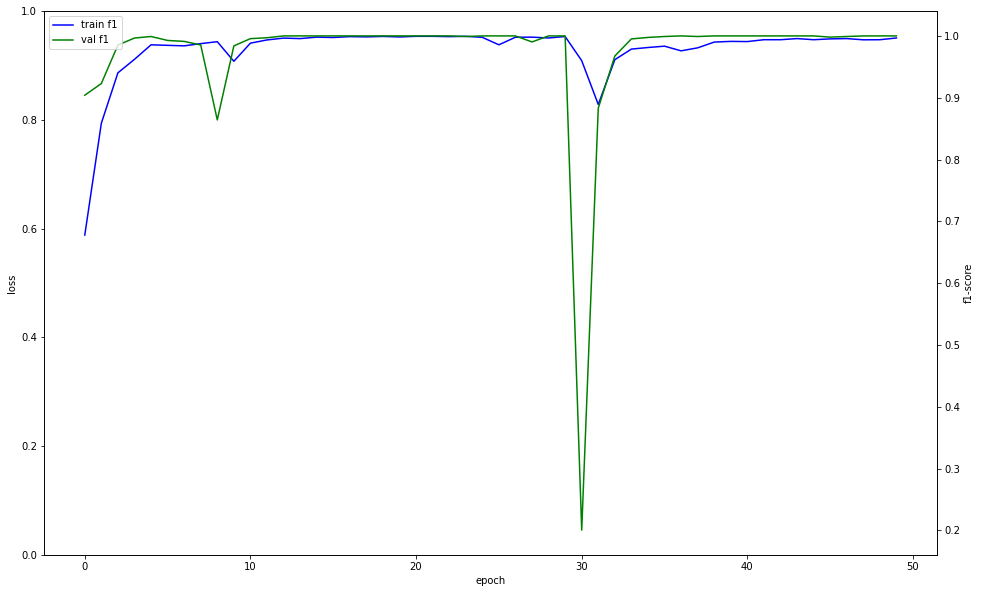

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history3.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history3.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

#### 5-3) Early Stopping 

- 여러 과적합을 해결하기 위한 방법을 적용시키고 있는데 바로 위 그래프만 살펴보더라도 특정 숫자(1.0) 근처로 값들의 변동이 있음을 확인할 수 있습니다. 여기 이상으로 학습이 안된다는 의미로 해석할 수 있습니다.
- 이때, 학습이 안되는 시점에서 빠르게 학습을 종료하는 Early Stopping 기법을 이용하여 과하게 학습됨을 방지하겠습니다.


- **tensorflow.keras.callbacks.EarlyStopping(monitor, min_deltam patience, verbose, mode, baseline, restore_best_weights)**
    - monitor : EarlyStopping의 기준이 되는 값
    - min_delta : 개선된 것으로 간주하기 위한 최소한의 변화량
    - patience : monitor가 개선되지 않을 때 몇 번의 epoch를 진행할 지 정하는 값
    - verbose : 0(화면 나타냄x) or 1(화면 나타냄o)
    - mode : monitor의 값이 어떤 mode가 되어야 하는지 알려주는 값
        - auto
        - min
        - max
    - baseline : 모형이 달성해야 하는 최소한의 기준값, patience 이내에서 모형이 baseline 기준으로 개선됨이 보이지 않으면 중단시킨다.
    - restore_best_weights : True(가장 좋을때의 training weight) or False(마지막 training weights)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

model4 = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.5),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(actions), activation='softmax')
])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_metric_F1score', min_delta = 0, patience = 20, mode = 'auto')


history4 = model4.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto'),
        early_stopping
    
    ]
)

Epoch 1/50
94/94 [==============================] - 3s 13ms/step - loss: 1.4969 - acc: 0.3849 - metric_F1score: 0.3043 - val_loss: 0.6401 - val_acc: 0.8527 - val_metric_F1score: 0.6680

Epoch 00001: val_acc improved from -inf to 0.85271, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/50
94/94 [==============================] - 1s 5ms/step - loss: 0.8276 - acc: 0.6607 - metric_F1score: 0.6239 - val_loss: 0.3299 - val_acc: 0.9319 - val_metric_F1score: 0.9170

Epoch 00002: val_acc improved from 0.85271 to 0.93186, saving model to models\multi_hand_gesture_classifier.h5
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 0.5768 - acc: 0.7944 - metric_F1score: 0.7660 - val_loss: 0.2087 - val_acc: 0.9479 - val_metric_F1score: 0.9483

Epoch 00003: val_acc improved from 0.93186 to 0.94790, saving model to models\multi_hand_gesture_classifier.h5
Epoch 4/50
94/94 [==============================] - 0s 4ms/step - loss: 0.4423 - acc: 0.8692 - metric_F1score: 0.8

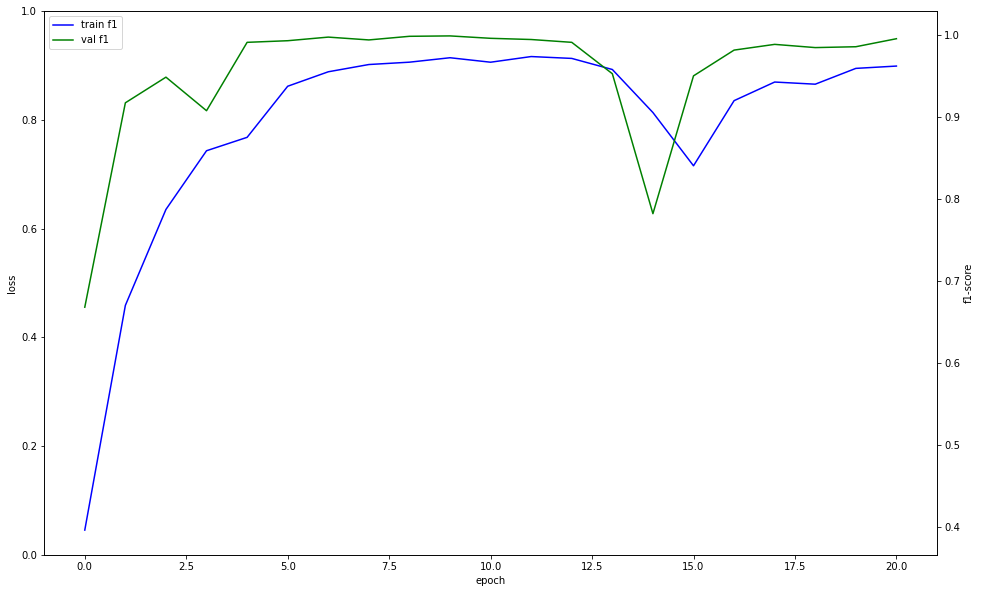

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history4.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history4.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

#### 5-4) 규제 방법 적용


**Regularization(정규화, 규제, 일반화)** 이란 모델이 과적합이 되도록 학습하지 않고 일반성을 가질 수 있도록 **가중치(weight)** 를 조정하여 규제하는 것을 의미합니다.

대표적으로 L1 규제(Lasso)와 L2 규제(Lidge)가 있습니다.

L1 규제에서 가장 중요한 것은 손실 함수(loss function)에 **가중치의 절대값**을 더해 준다는 것입니다. L1 규제는 아래의 수식처럼 표현할 수 있습니다.

<img src ="https://drive.google.com/uc?export=view&id=1MAMqFj7eH9TfjQ80Ir2usXeaAlan0eOp">

L1 규제의 경우에는 가중치의 크기에 상관없이 상수값을 뺍니다. 이는 대체적으로 불필요한 가중치의 수치를 0으로 만들도록 하는 방향으로 적용됩니다. 즉, 중요한 가중치만을 취하기 때문에 희소 데이터(sparse feature)에 대한 모델을 구성하는데 적합합니다.

In [ ]:
#기본 모델 + l1 규제
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras.layers

model5 = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3], kernel_regularizer=keras.regularizers.l1(0.01)),
    Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l1(0.01))
])



model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history5 = model5.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
94/94 [==============================] - 2s 8ms/step - loss: 24.8018 - acc: 0.6969 - metric_F1score: 0.6971 - val_loss: 12.1133 - val_acc: 0.9248 - val_metric_F1score: 0.9178

Epoch 00001: val_acc improved from -inf to 0.92485, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/50
94/94 [==============================] - 0s 5ms/step - loss: 10.9349 - acc: 0.9323 - metric_F1score: 0.9325 - val_loss: 8.7661 - val_acc: 0.9449 - val_metric_F1score: 0.9463

Epoch 00002: val_acc improved from 0.92485 to 0.94489, saving model to models\multi_hand_gesture_classifier.h5
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 8.3471 - acc: 0.9466 - metric_F1score: 0.9466 - val_loss: 7.2125 - val_acc: 0.9729 - val_metric_F1score: 0.9741

Epoch 00003: val_acc improved from 0.94489 to 0.97295, saving model to models\multi_hand_gesture_classifier.h5
Epoch 4/50
94/94 [==============================] - 0s 4ms/step - loss: 6.8617 - acc: 0.9872 - metric_F1score: 0


Epoch 00033: val_acc did not improve from 1.00000
Epoch 34/50
94/94 [==============================] - 0s 4ms/step - loss: 1.5927 - acc: 1.0000 - metric_F1score: 1.0000 - val_loss: 1.5474 - val_acc: 0.9990 - val_metric_F1score: 0.9990

Epoch 00034: val_acc did not improve from 1.00000
Epoch 35/50
94/94 [==============================] - 0s 4ms/step - loss: 1.5292 - acc: 0.9999 - metric_F1score: 0.9999 - val_loss: 1.4905 - val_acc: 1.0000 - val_metric_F1score: 1.0000

Epoch 00035: val_acc did not improve from 1.00000
Epoch 36/50
94/94 [==============================] - 0s 4ms/step - loss: 1.4717 - acc: 1.0000 - metric_F1score: 1.0000 - val_loss: 1.4263 - val_acc: 1.0000 - val_metric_F1score: 1.0000

Epoch 00036: val_acc did not improve from 1.00000
Epoch 37/50
94/94 [==============================] - 0s 4ms/step - loss: 1.4163 - acc: 0.9993 - metric_F1score: 0.9993 - val_loss: 1.3984 - val_acc: 0.9990 - val_metric_F1score: 0.9990

Epoch 00037: val_acc did not improve from 1.00000
Epoch

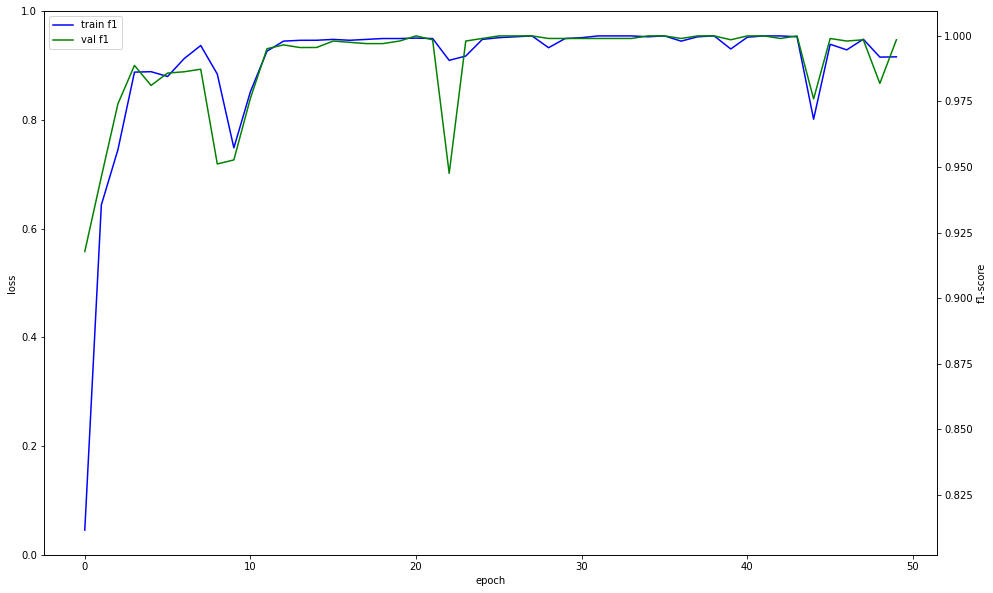

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history5.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history5.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

L2 규제는 기존의 손실 함수(loss function)에 **가중치의 제곱**을 더함으로써 L1 규제와 마찬가지로 가중치가 너무 크지 않은 방향으로 학습하도록 합니다. L2 규제는 아래의 수식처럼 표현 할 수 있습니다.

<img src ="https://drive.google.com/uc?export=view&id=1-LqVTy67vbM2B6nR1RxfbqeQ5wkYZdzH">

L2의 경우에는 가중치의 값을 이용합니다. 이상치나 노이즈가 있는 데이터에 대한 학습을 진행할 때 사용하면 좋습니다. 특히 선형 모델(Linear model)의 일반화에 좋다고 합니다.     

In [ ]:
#기본 모델 + l2 규제
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras.layers

model5 = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3], kernel_regularizer=keras.regularizers.l2(0.01)),
    Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
])



model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history5 = model5.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
94/94 [==============================] - 2s 11ms/step - loss: 19.9825 - acc: 0.6092 - metric_F1score: 0.6081 - val_loss: 3.0308 - val_acc: 0.8607 - val_metric_F1score: 0.8600

Epoch 00001: val_acc improved from -inf to 0.86072, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/50
94/94 [==============================] - 0s 4ms/step - loss: 2.8315 - acc: 0.8832 - metric_F1score: 0.8835 - val_loss: 1.3683 - val_acc: 0.9699 - val_metric_F1score: 0.9706

Epoch 00002: val_acc improved from 0.86072 to 0.96994, saving model to models\multi_hand_gesture_classifier.h5
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 1.2576 - acc: 0.9770 - metric_F1score: 0.9769 - val_loss: 1.1658 - val_acc: 0.9840 - val_metric_F1score: 0.9838

Epoch 00003: val_acc improved from 0.96994 to 0.98397, saving model to models\multi_hand_gesture_classifier.h5
Epoch 4/50
94/94 [==============================] - 0s 4ms/step - loss: 1.1326 - acc: 0.9845 - metric_F1score: 0.


Epoch 00033: val_acc did not improve from 1.00000
Epoch 34/50
94/94 [==============================] - 0s 4ms/step - loss: 0.3398 - acc: 1.0000 - metric_F1score: 1.0000 - val_loss: 0.3323 - val_acc: 1.0000 - val_metric_F1score: 1.0000

Epoch 00034: val_acc did not improve from 1.00000
Epoch 35/50
94/94 [==============================] - 0s 4ms/step - loss: 0.3298 - acc: 1.0000 - metric_F1score: 1.0000 - val_loss: 0.3296 - val_acc: 0.9970 - val_metric_F1score: 0.9976

Epoch 00035: val_acc did not improve from 1.00000
Epoch 36/50
94/94 [==============================] - 0s 4ms/step - loss: 0.3268 - acc: 0.9979 - metric_F1score: 0.9979 - val_loss: 0.3154 - val_acc: 1.0000 - val_metric_F1score: 1.0000

Epoch 00036: val_acc did not improve from 1.00000
Epoch 37/50
94/94 [==============================] - 0s 4ms/step - loss: 0.3128 - acc: 1.0000 - metric_F1score: 1.0000 - val_loss: 0.3059 - val_acc: 1.0000 - val_metric_F1score: 1.0000

Epoch 00037: val_acc did not improve from 1.00000
Epoch

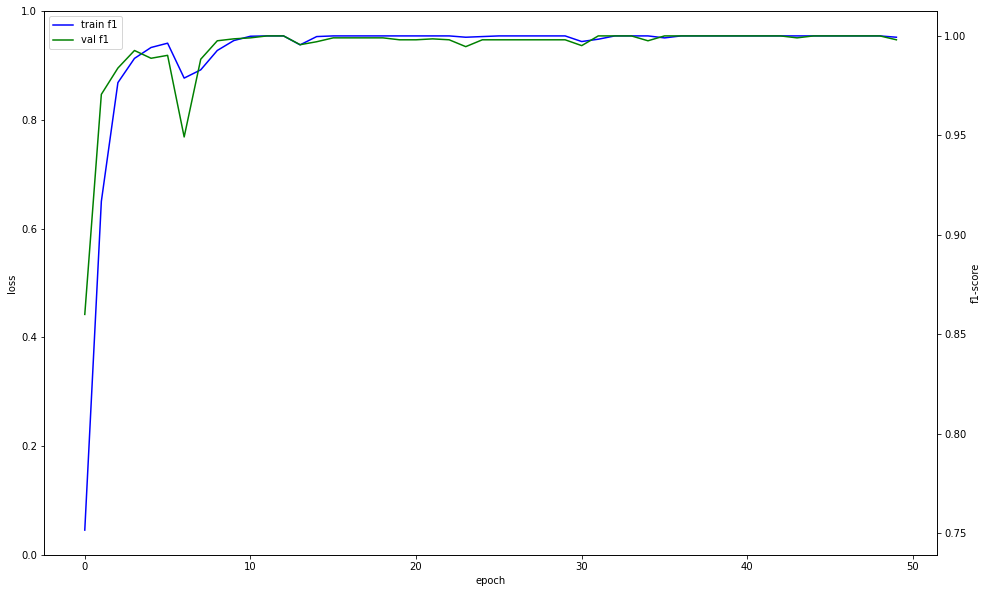

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history5.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history5.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

이제 위 규제 방법들을 활용하여 가장 최적으로 데이터를 잘 학습시킨 모형을 찾아보겠습니다.

### 6. 최종 모형

위 데이터에 가장 잘 적합한다고 생각한 최종모형은 LSTM에 L2 규제를 적용하고 30%의 Dropout과 Early Stopping을 적용한 모형입니다. 여러 실험을 해보았는데, 우선 데이터가 쉬워서 무슨 모형을 해도 과적합이 되기 때문에 천천히 1에 도달하는 모형을 select 했습니다.

In [ ]:
#기본 모델 + ㅣ2 규제 + dropout 30% + early stopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras.layers

model7 = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3], kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(len(actions), activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
])



model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metric_F1score])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_metric_F1score', min_delta = 0, patience = 20, mode = 'auto')


history7 = model7.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_metric_F1score', factor=0.5, patience=50, verbose=1, mode='auto'),
        early_stopping
    
    ]
)

Epoch 1/50
94/94 [==============================] - 2s 7ms/step - loss: 14.1750 - acc: 0.3844 - metric_F1score: 0.3844 - val_loss: 1.7649 - val_acc: 0.9339 - val_metric_F1score: 0.8780

Epoch 00001: val_acc improved from -inf to 0.93387, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/50
94/94 [==============================] - 0s 4ms/step - loss: 2.3318 - acc: 0.7341 - metric_F1score: 0.7322 - val_loss: 1.2715 - val_acc: 0.9479 - val_metric_F1score: 0.9442

Epoch 00002: val_acc improved from 0.93387 to 0.94790, saving model to models\multi_hand_gesture_classifier.h5
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 1.5817 - acc: 0.8421 - metric_F1score: 0.8477 - val_loss: 1.0190 - val_acc: 0.9800 - val_metric_F1score: 0.9794

Epoch 00003: val_acc improved from 0.94790 to 0.97996, saving model to models\multi_hand_gesture_classifier.h5
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 1.2509 - acc: 0.9088 - metric_F1score: 0.8

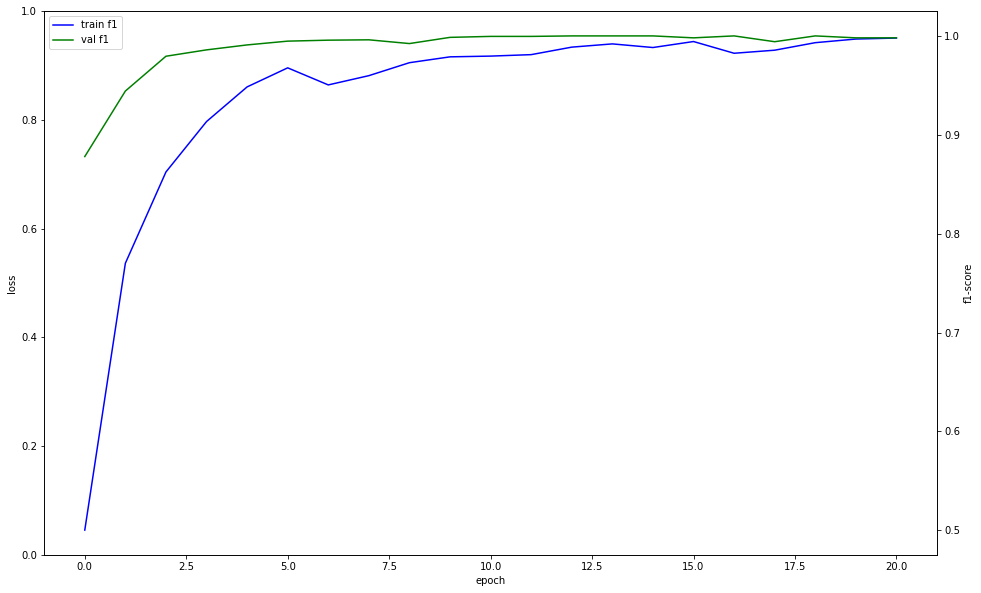

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')


acc_ax.plot(history7.history['metric_F1score'], 'b', label='train f1')
acc_ax.plot(history7.history['val_metric_F1score'], 'g', label='val f1')
acc_ax.set_ylabel('f1-score')
acc_ax.legend(loc='upper left')

plt.show()

### 7. 결론

최종 모형으로 선택한 모형은 3가지의 규제 방법을 쓴 모형입니다.
하지만, 위 모형으로 하여 test를 진행하였을 때, **중심에서는 인식을 잘 하지만 영상의 외곽으로 손동작이 갈수록 인식을 잘 못하는 경향이 나타났습니다**.
이에, 2편에서는 영상 외곽에서도 손동작을 잘 인식하려면 어떻게 해야하는지에 관한 게시글을 작성하려고 합니다.

## [마무리]

- **5월 24일 오후 2시에 만나요🔥✨**

# 감사합니다 :)